# Evaluating the radius (r) parameter

In [43]:
import os
os.chdir('/home/sebastiaan/PhD/Repositories/immune_response_detection/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from raptcr.indexing import FlatIndex
from raptcr.hashing import TCRDistEncoder
from raptcr.neighbors import tcr_dict_to_df, index_neighbors

### Helper functions

In [6]:
def result_to_df(nbrs):
    '''
    Format radius search results into a pd.DataFrame.
    '''
    res = pd.DataFrame([i[0].split('_') for i in nbrs], columns=['v_call', 'junction_aa'])
    res['distance'] = [i[1] for i in nbrs]
    return res.sort_values(by='distance')

def calculate_purity(df, r):
    '''
    Calculate neighborhood purity at distance threshold r.
    '''
    cutoff = df[df.distance<=r]
    total = cutoff.shape[0]
    top = cutoff.peptide.value_counts()[0]
    purity = top / total
    return purity, total

def radius_range(results_df, mindist=5, maxdist=201, stepsize=5):
    '''
    Evaluate cluster purity at different values for r.
    
    Parameters
    ----------
    results_df
        pd.DataFrame containing all neighbors relative to one sequence
        along with the distances and epitope annotations.
    mindist
        Lower limit for radius range.
    maxdist
        Upper limit for radius range.
    stepsize
        Number of r units per iteration.
    '''
    radii = np.arange(mindist, maxdist+1, 5)
    purity = []
    ncluster = []
    
    for r in radii:
        try:
            f, n = calculate_purity(results_df, r=r)
        except IndexError:
            f = 0
            n = 0
        purity.append(f)
        ncluster.append(n)

    return pd.DataFrame(
        {'radius':radii,
         'purity':purity,
         'ncluster':ncluster}
    )

def radius_scan(df, ndim=16, rmax=180):
    # Set up index for searching
    encoder = TCRDistEncoder(aa_dim=ndim, full_tcr=True).fit()
    index = FlatIndex(hasher=encoder)
    index.add(df)
    # Perform search for all sequences in data
    allres = []
    for i in range(df.shape[0]):
        q = pd.DataFrame(df.loc[i]).T
        res = result_to_df(index.radius_search(q, rmax))
        merged = res.merge(df)
        final = radius_range(merged)
        final['tcr_id'] = i
        final['cdr3_length'] = q.junction_aa.str.len()[i]
        allres.append(final)
    return pd.concat(allres)


## **Pregibon dataset**
Small dataset containing paired chain ($\alpha\beta$) epitope-specific TCRs.

### Preprocessing

In [7]:
pregibon = pd.read_csv('./data/phil/pregibon_tcrs.tsv', sep='\t')

test = pregibon[['peptide','cdr3b','vb']].drop_duplicates()
test = test.rename(columns={'cdr3b':'junction_aa', 'vb':'v_call'})
test = test.reset_index(drop=True)
print(test.shape)
test.head()

(786, 3)


,peptide,junction_aa,v_call
0,CTELKLSDY,CAISESNDGNEQFF,TRBV10-3*01
1,CTELKLSDY,CASTLGTSHDYEQYF,TRBV7-6*01
2,CTELKLSDY,CAISESLGQDQQYF,TRBV10-3*01
3,CTELKLSDY,CAISESRSSGADTQYF,TRBV10-3*01
4,CTELKLSDY,CAISESTGLRDEQFF,TRBV10-3*01


In [46]:
# index_neighbors(query=x, index=index, r=100)

{'TRBV10-3*01_CAISESNDGNEQFF': 63}

In [86]:
test.junction_aa.str.len().value_counts()

13    218
14    146
15    131
16    130
12     57
17     50
18     21
11     19
19      7
20      5
10      1
21      1
Name: junction_aa, dtype: int64

In [164]:
encoder = TCRDistEncoder().fit()
index = FlatIndex(hasher=encoder)

# fig, ax = plt.subplots(dpi=150, figsize=(3,3))
index.add(test)

radii = np.arange(10,101.0,1)
len_pur = {
    "min":([],[]),
    12:([],[]),
    13:([],[]),
    14:([],[]),
    15:([],[]),
    16:([],[]),
    17:([],[]),
    "max":([],[])}
min_len = 12
max_len = 17
for i in range(len(test)):
    x = pd.DataFrame(test.iloc[i]).T
    cdr3len = len(x.junction_aa.iloc[0])
    pur = []
    count = []
    for i in radii:
        res = index.radius_search(query=x, r=i, exclude_self=False)
        res = result_to_df(res)
        max_epi = res.merge(test).peptide.value_counts().max()
        pur.append(max_epi/res.shape[0])
        count.append(res.shape[0])
        allradii.append(i)
    if cdr3len < min_len:
        len_pur["min"][0].append(pur)
        len_pur["min"][1].append(count)
    elif cdr3len > max_len:
        len_pur["max"][0].append(pur)
        len_pur["max"][1].append(count)
    else:
        len_pur[cdr3len][0].append(pur)
        len_pur[cdr3len][1].append(count)
    # ax.plot(radii,pur)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.11764706, 1.11764706, 1.17647059,
       1.17647059, 1.17647059, 1.17647059, 1.17647059, 1.23529412,
       1.23529412, 1.23529412, 1.23529412, 1.29411765, 1.41176471,
       1.58823529, 1.58823529, 1.58823529, 1.64705882, 1.64705882,
       1.64705882, 1.64705882, 1.70588235, 1.70588235, 1.70588235,
       1.70588235, 1.76470588, 1.76470588, 1.97058824, 2.08823529,
       2.08823529, 2.14705882, 2.17647059, 2.17647059, 2.17647059,
       2.17647059, 2.23529412, 2.23529412, 2.38235294, 2.38235294,
       2.44117647, 2.44117647, 2.52941176, 2.61764706, 2.64705882,
       2.85294118, 2.85294118, 2.91176471, 3.05882353, 3.08823

min
12
13
14
15
16
17
max


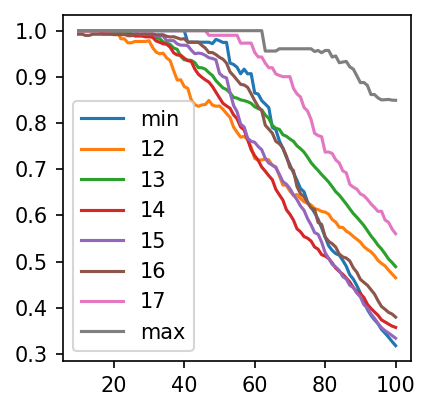

In [122]:
fig, ax = plt.subplots(dpi=150,figsize=(3,3))

for length in len_pur:
    print(length)
    avg_purity = np.average(np.array(len_pur[length]),axis=0)
    ax.plot(radii, avg_purity, label=f"{length}")
ax.legend()

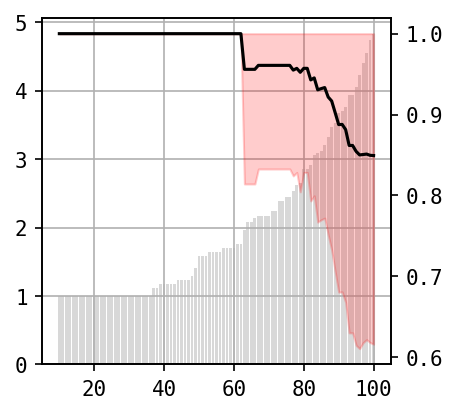

In [194]:
fig, ax = plt.subplots(dpi=150,figsize=(3,3))
ax2 = ax.twinx()
avg = np.average(np.array(len_pur[l][0]),axis=0)
std = np.std(np.array(len_pur[l][0]),axis=0)
y1 = [1 if i > 1 else i for i in avg+std]
y2 = avg-std
ax2.plot(radii,avg,c="black")
ax.bar(radii,np.average(np.array(len_pur[l][1]),axis=0),color="grey",alpha=.3)
ax.grid()
ax2.fill_between(x=radii,y1=y1,y2=y2,color="red",alpha=.2)

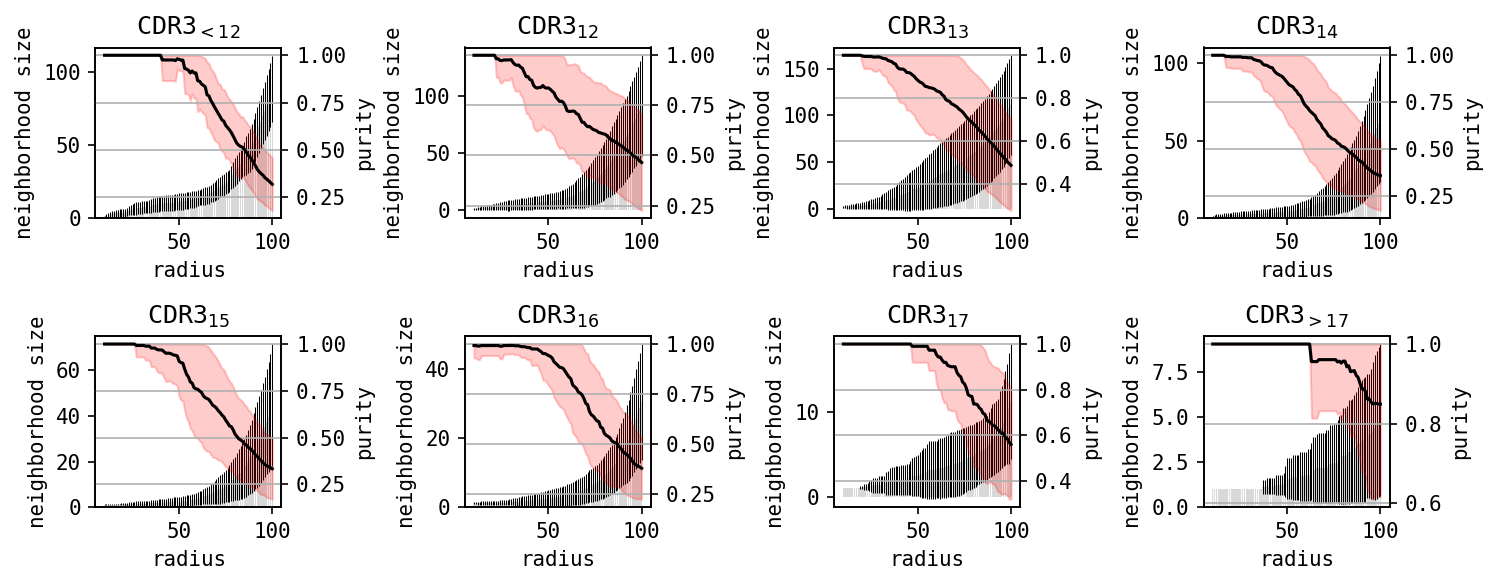

In [210]:
plt.rcParams["font.family"] = "monospace"

fig, axes = plt.subplots(dpi=150, figsize=(10,4), nrows=2, ncols=4)
for ax, l in zip(axes.ravel(), len_pur):
    avg = np.average(np.array(len_pur[l][0]),axis=0)
    std = np.std(np.array(len_pur[l][0]),axis=0)
    y1 = [1 if i > 1 else i for i in avg+std]
    y2 = avg-std
    ax2 = ax.twinx()
    ax2.plot(radii,avg,c="black")
    ax2.grid()
    ax2.fill_between(x=radii,y1=y1,y2=y2,color="red",alpha=.2)
    # ax.errorbar(
    #     x=radii,
    #     y=np.average(np.array(len_pur[l][1]),axis=0),
    #     yerr=np.std(np.array(len_pur[l][1]),axis=0),
    #     # fmt="o",
    #     elinewidth=.5,
    #     color="black",
    #     alpha=.8
    #     )
    ax.bar(
        x=radii,
        height=np.average(np.array(len_pur[l][1]),axis=0),
        yerr=np.std(np.array(len_pur[l][1]),axis=0),
        color="grey",
        error_kw={"elinewidth":.5},
        alpha=.3
        )
    ax.set_xlabel("radius")
    ax.set_ylabel("neighborhood size")
    ax2.set_ylabel("purity")
    if l == "min":
        lab = "<12"
    elif l == "max":
        lab = ">17"
    else:
        lab = l
    ax.set_title(r"CDR3$_{%s}$" % (lab))
    # ax.set_xticklabels([0,25,50,75,100])
fig.tight_layout()
fig.savefig("./fig/radius_vs_purity_vs_length.png", format="png", dpi=150)

### Compute radii

In [8]:
result = radius_scan(test)

In [9]:
result

,radius,purity,ncluster,tcr_id,cdr3_length
0,5,0.000000,0,0,14
1,10,0.000000,0,0,14
2,15,0.000000,0,0,14
3,20,0.000000,0,0,14
4,25,0.000000,0,0,14
...,...,...,...,...,...
35,180,0.158816,743,785,14
36,185,0.158816,743,785,14
37,190,0.158816,743,785,14
38,195,0.158816,743,785,14


### Plot results

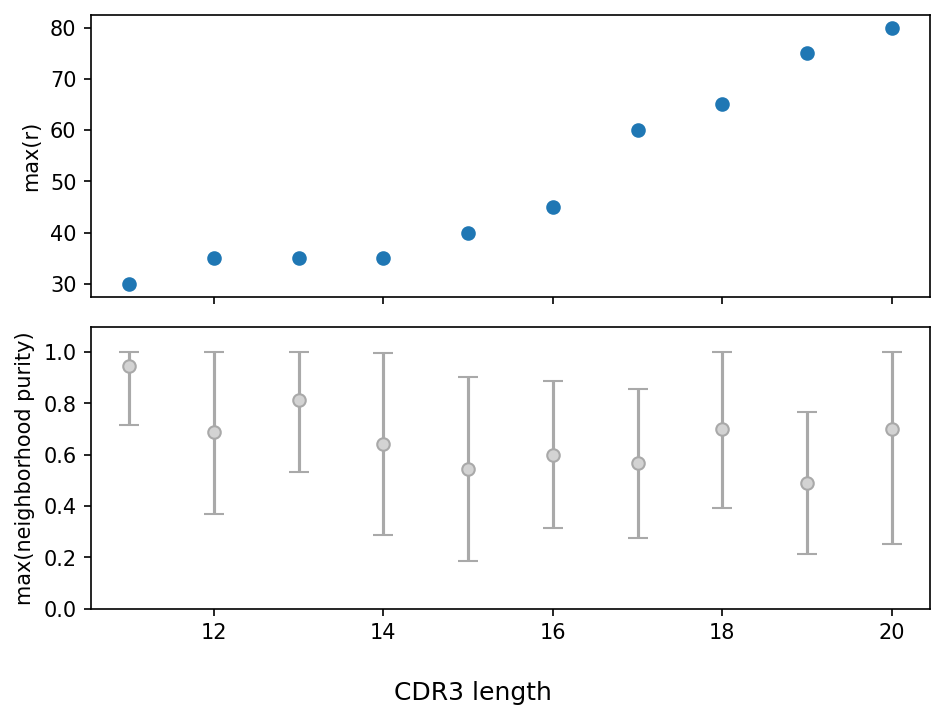

In [82]:
lengths = sorted(result.cdr3_length.unique())
rmax = [result[result.cdr3_length==l].groupby('radius').mean().purity.idxmax() for l in lengths]
pmax = [result[result.cdr3_length==l].groupby('radius').mean().purity.max() for l in lengths]
maxstd = [result[result.cdr3_length==l].groupby('radius').std().purity[r] for l, r in zip(lengths,rmax)]

x = lengths[1:-1]
y1 = rmax[1:-1]
y2 = pmax[1:-1]
err = maxstd[1:-1]
y2_upper = [i+j if i+j <= 1 else 1 for i,j in zip(y2,err)]
y2_lower = [i-j for i,j in zip(y2,err)]

y_l = np.array(y2) - np.array(y2_lower)
y_u =np.array(y2_upper) - np.array(y2)

errors = [y_l, y_u]

fig, ax = plt.subplots(nrows=2, ncols=1, dpi=150, sharex=True)
ax[0].scatter(x=x, y=y1)
ax[1].errorbar(x=x, y=y2, yerr=errors, marker='o', markerfacecolor='lightgray', ls='', capsize=5, c='darkgray')

ax[0].set_ylabel('max(r)')
ax[1].set_ylabel('max(neighborhood purity)')
ax[1].set_ylim(0,1.1)
fig.supxlabel('CDR3 length')
fig.tight_layout()

/tmp/ipykernel_103651/2310792083.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i[0],i[1]].set_xticklabels([0,50,100,150], fontsize=6)
/tmp/ipykernel_103651/2310792083.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i[0],i[1]].set_xticklabels([0,50,100,150], fontsize=6)
/tmp/ipykernel_103651/2310792083.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i[0],i[1]].set_xticklabels([0,50,100,150], fontsize=6)
/tmp/ipykernel_103651/2310792083.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i[0],i[1]].set_xticklabels([0,50,100,150], fontsize=6)
/tmp/ipykernel_103651/2310792083.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i[0],i[1]].set_xticklabels([0,50,100,150], fontsize=6)
/tmp/ipykernel_103651/2310792083.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator


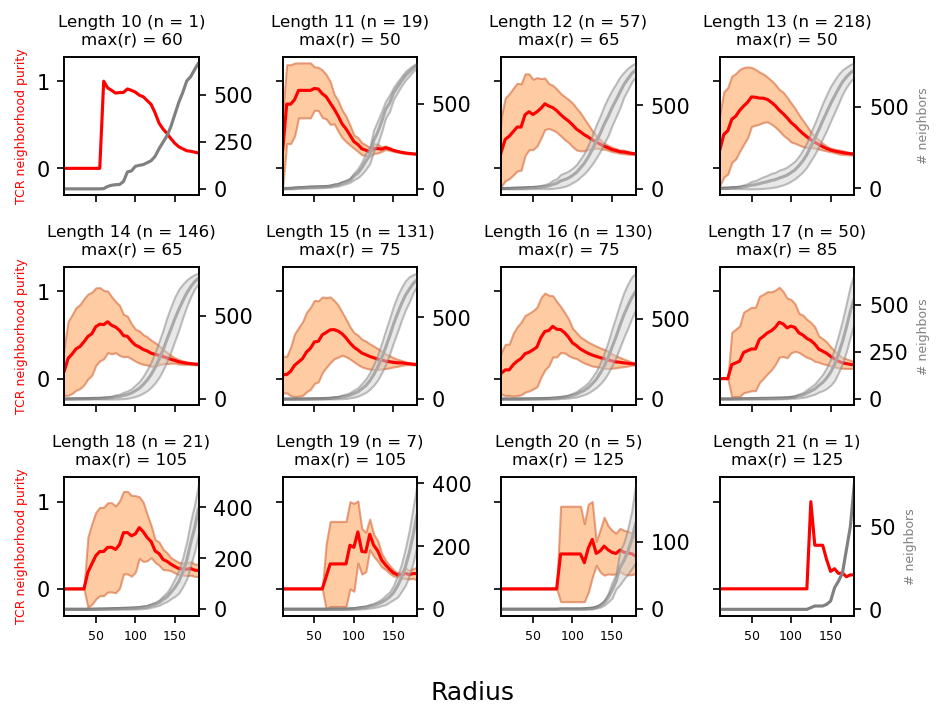

In [10]:
axi = [
    [0,0],[0,1],[0,2],[0,3],
    [1,0],[1,1],[1,2],[1,3],
    [2,0],[2,1],[2,2],[2,3]
    ]

fig, axes = plt.subplots(nrows=3, ncols=4, dpi=150, sharex=True, sharey=True)

lengths = sorted(result.cdr3_length.unique())
for i, l in zip(axi,lengths):
    
    len_df = result[result.cdr3_length==l]
    len_df_avg = len_df.groupby('radius').mean()
    len_df_std = len_df.groupby('radius').std()
    ntcr = len(len_df.tcr_id.unique())

    pmax = np.round(len_df_avg.purity.max(), 2)
    maxid = len_df_avg.purity.idxmax()
    stdmax = np.round(len_df_std.purity[maxid], 2)

    x = len_df_avg.index
    y1 = len_df_avg.purity
    y2 = len_df_avg.ncluster
    error1 = len_df_std.purity
    error2 = len_df_std.ncluster

    cdr3str = 'CDR3'
    axes[i[0],i[1]].fill_between(x, y1-error1, y1+error1, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848', zorder=1)
    axes[i[0],i[1]].plot(x, y1, color='red', zorder=1)
    axes[i[0],i[1]].set_xlim(10,180)
    axes[i[0],i[1]].set_title(f'Length {l} (n = {ntcr})\nmax(r) = {maxid}', fontsize=8)
    axes[i[0],i[1]].set_xticklabels([0,50,100,150], fontsize=6)
    if i[1] == 0:
        axes[i[0],i[1]].set_ylabel('TCR neighborhood purity', color='red', fontsize=6)

    ax2 = axes[i[0],i[1]].twinx()
    ax2.fill_between(x, y2-error2, y2+error2, alpha=0.5, edgecolor='grey', facecolor='lightgray')
    ax2.plot(x, y2, color='grey', zorder=0)
    if i[1] == 3:
        ax2.set_ylabel('# neighbors', color='grey', fontsize=6)

# fig.supylabel('TCR neighborhood purity')
fig.supxlabel('Radius')
fig.tight_layout()
# fig.savefig('./fig/radius_length.png', dpi=500, format='png')

gapped_encode_tcr_chains: aa_mds_dim=1
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=34
gapped_encode_tcr_chains: aa_mds_dim=1
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=34
gapped_encode_tcr_chains: aa_mds_dim=1
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=34
gapped_encode_tcr_chains: aa_mds_dim=1
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=34
gapped_encode_tcr_chains: aa_mds_dim=1
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=34
gapped_encode_tcr_chains: aa_mds_dim=1
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=34
gapped_encode_tcr_chains: aa_mds_dim=1
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=34
gapped_encode_tcr_chains: aa_mds_dim=1
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=34
gapped_encode_tcr_chains: aa_mds_dim=1
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=34
gapped_encode_tcr_chains: aa_mds_dim=1
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=34
gapped_encode_tcr_chains: aa_mds_dim=1
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=34
gapped_encode_tcr_cha

/tmp/ipykernel_78816/220524656.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i[0],i[1]].set_xticklabels([0,50,100,150], fontsize=6)


gapped_encode_tcr_chains: aa_mds_dim=2
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=68
gapped_encode_tcr_chains: aa_mds_dim=2
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=68
gapped_encode_tcr_chains: aa_mds_dim=2
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=68
gapped_encode_tcr_chains: aa_mds_dim=2
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=68
gapped_encode_tcr_chains: aa_mds_dim=2
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=68
gapped_encode_tcr_chains: aa_mds_dim=2
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=68
gapped_encode_tcr_chains: aa_mds_dim=2
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=68
gapped_encode_tcr_chains: aa_mds_dim=2
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=68
gapped_encode_tcr_chains: aa_mds_dim=2
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=68
gapped_encode_tcr_chains: aa_mds_dim=2
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=68
gapped_encode_tcr_chains: aa_mds_dim=2
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=68
gapped_encode_tcr_cha

/tmp/ipykernel_78816/220524656.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i[0],i[1]].set_xticklabels([0,50,100,150], fontsize=6)


gapped_encode_tcr_chains: aa_mds_dim=4
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=136
gapped_encode_tcr_chains: aa_mds_dim=4
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=136
gapped_encode_tcr_chains: aa_mds_dim=4
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=136
gapped_encode_tcr_chains: aa_mds_dim=4
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=136
gapped_encode_tcr_chains: aa_mds_dim=4
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=136
gapped_encode_tcr_chains: aa_mds_dim=4
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=136
gapped_encode_tcr_chains: aa_mds_dim=4
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=136
gapped_encode_tcr_chains: aa_mds_dim=4
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=136
gapped_encode_tcr_chains: aa_mds_dim=4
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=136
gapped_encode_tcr_chains: aa_mds_dim=4
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=136
gapped_encode_tcr_chains: aa_mds_dim=4
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=136
gapped_enc

/tmp/ipykernel_78816/220524656.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i[0],i[1]].set_xticklabels([0,50,100,150], fontsize=6)


gapped_encode_tcr_chains: aa_mds_dim=8
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=272
gapped_encode_tcr_chains: aa_mds_dim=8
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=272
gapped_encode_tcr_chains: aa_mds_dim=8
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=272
gapped_encode_tcr_chains: aa_mds_dim=8
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=272
gapped_encode_tcr_chains: aa_mds_dim=8
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=272
gapped_encode_tcr_chains: aa_mds_dim=8
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=272
gapped_encode_tcr_chains: aa_mds_dim=8
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=272
gapped_encode_tcr_chains: aa_mds_dim=8
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=272
gapped_encode_tcr_chains: aa_mds_dim=8
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=272
gapped_encode_tcr_chains: aa_mds_dim=8
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=272
gapped_encode_tcr_chains: aa_mds_dim=8
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=272
gapped_enc

/tmp/ipykernel_78816/220524656.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i[0],i[1]].set_xticklabels([0,50,100,150], fontsize=6)


gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544

/tmp/ipykernel_78816/220524656.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i[0],i[1]].set_xticklabels([0,50,100,150], fontsize=6)


gapped_encode_tcr_chains: aa_mds_dim=32
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=1088
gapped_encode_tcr_chains: aa_mds_dim=32
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=1088
gapped_encode_tcr_chains: aa_mds_dim=32
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=1088
gapped_encode_tcr_chains: aa_mds_dim=32
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=1088
gapped_encode_tcr_chains: aa_mds_dim=32
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=1088
gapped_encode_tcr_chains: aa_mds_dim=32
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=1088
gapped_encode_tcr_chains: aa_mds_dim=32
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=1088
gapped_encode_tcr_chains: aa_mds_dim=32
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=1088
gapped_encode_tcr_chains: aa_mds_dim=32
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=1088
gapped_encode_tcr_chains: aa_mds_dim=32
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=1088
gapped_encode_tcr_chains: aa_mds_dim=32
 num_pos_other_cdrs=18 num_pos_cdr3=16 v

/tmp/ipykernel_78816/220524656.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i[0],i[1]].set_xticklabels([0,50,100,150], fontsize=6)


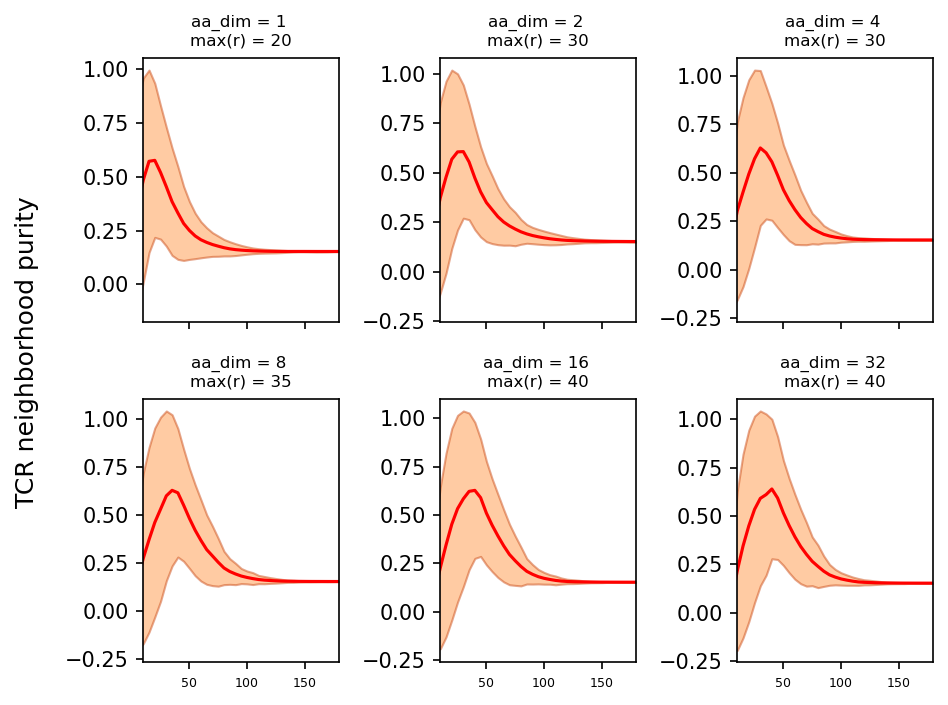

In [121]:
fig, ax = plt.subplots(nrows=2, ncols=3, dpi=150, sharex=True)

dims = [1,2,4,8,16,32]
axes = [[0,0],[0,1],[0,2],
        [1,0],[1,1],[1,2],]

for i, dim in zip(axes, dims):

    ndim = radius_scan(test, ndim=dim)

    ndim_avg = ndim.groupby('radius').mean()
    ndim_std = ndim.groupby('radius').std()
    ntcr = len(ndim.tcr_id.unique())

    pmax = np.round(ndim_avg.purity.max(), 2)
    maxid = ndim_avg.purity.idxmax()
    stdmax = np.round(ndim_std.purity[maxid], 2)

    x = ndim_avg.index
    y1 = ndim_avg.purity
    y2 = ndim_avg.ncluster
    error1 = ndim_std.purity
    error2 = ndim_std.ncluster

    ax[i[0],i[1]].fill_between(x, y1-error1, y1+error1, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848', zorder=1)
    ax[i[0],i[1]].plot(x, y1, color='red', zorder=1)
    ax[i[0],i[1]].set_xlim(10,180)
    ax[i[0],i[1]].set_title(f'aa_dim = {dim} \nmax(r) = {maxid}', fontsize=8)
    ax[i[0],i[1]].set_xticklabels([0,50,100,150], fontsize=6)

fig.supylabel('TCR neighborhood purity')
fig.tight_layout()

# axes[0,0]


# axes[i[0],i[1]].set_xlabel('Radius')
# axes[i[0],i[1]].set_supylabel('TCR neighborhood purity')
# axes[i[0],i[1]].set_title('Effect of radius on purity of TCR neighborhood')

# ax2 = axes[i[0],i[1]].twinx()
# ax2.fill_between(x, y2-error2, y2+error2, alpha=0.5, edgecolor='grey', facecolor='lightgray')
# ax2.plot(x, y2, color='grey', zorder=0)
# ax2.set_ylabel('# neighbors')

## **CONGA dataset**

In [3]:
conga = pd.read_csv('./data/phil/conga_lit_db.tsv', sep='\t')
# conga = pd.read_csv('./data/phil/pregibon_tcrs.tsv', sep='\t')
conga = conga[['epitope','cdr3b','vb']].drop_duplicates()
conga = conga.rename(columns={'cdr3b':'junction_aa', 'vb':'v_call', 'epitope':'peptide'})
conga = conga.reset_index(drop=True)
conga = conga.dropna(subset='peptide')
print(conga.shape)

conga.head()

(2554, 3)


,peptide,junction_aa,v_call
0,AAGIGILTV,CAISEVGVGQPQHF,TRBV10-3*01
1,AAGIGILTV,CAWSETGLGTGELFF,TRBV30*01
2,AAGIGILTV,CASSLSFGTEAFF,TRBV6-4*01
3,AAGIGILTV,CASSWSFGTEAFF,TRBV6-4*01
4,AAVVRFQEAANKQKQ,CSARASGGEAKNIQYF,TRBV20-1*01


In [175]:
conga_result = radius_scan(conga, ndim=16)

gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544

/tmp/ipykernel_78816/3281612202.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i[0],i[1]].set_xticklabels([0,50,100,150], fontsize=6)
/tmp/ipykernel_78816/3281612202.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i[0],i[1]].set_xticklabels([0,50,100,150], fontsize=6)
/tmp/ipykernel_78816/3281612202.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i[0],i[1]].set_xticklabels([0,50,100,150], fontsize=6)
/tmp/ipykernel_78816/3281612202.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i[0],i[1]].set_xticklabels([0,50,100,150], fontsize=6)
/tmp/ipykernel_78816/3281612202.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i[0],i[1]].set_xticklabels([0,50,100,150], fontsize=6)
/tmp/ipykernel_78816/3281612202.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes

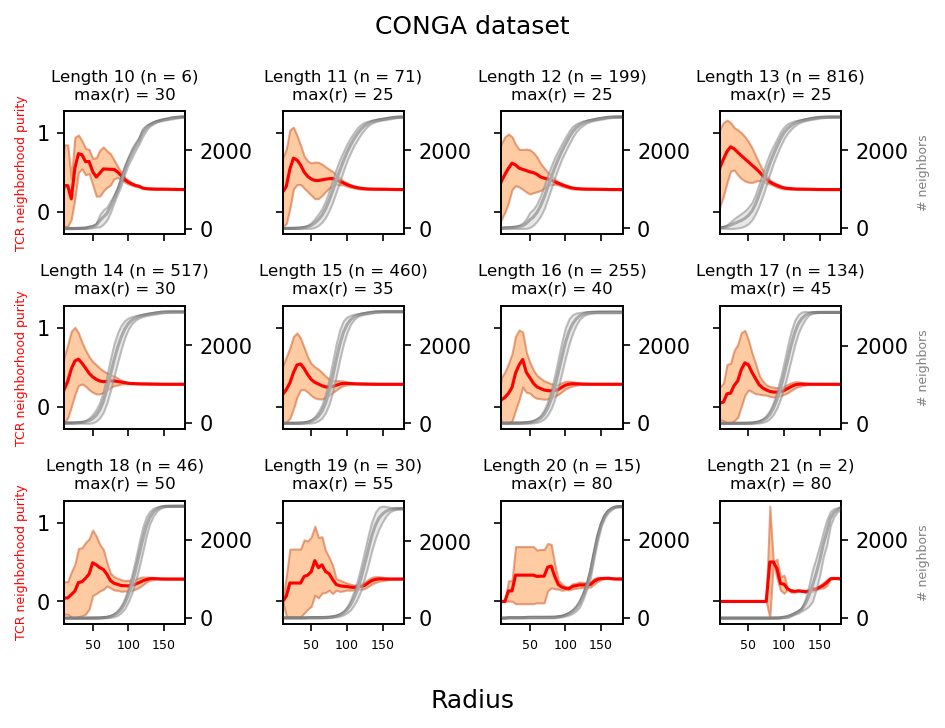

In [182]:
axi = [
    [0,0],[0,1],[0,2],[0,3],
    [1,0],[1,1],[1,2],[1,3],
    [2,0],[2,1],[2,2],[2,3]
    ]

fig, axes = plt.subplots(nrows=3, ncols=4, dpi=150, sharex=True, sharey=True)

lengths = sorted(conga_result.cdr3_length.unique())
lengths = lengths[1:-1]
for i, l in zip(axi,lengths):
    
    len_df = conga_result[conga_result.cdr3_length==l]
    len_df_avg = len_df.groupby('radius').mean()
    len_df_std = len_df.groupby('radius').std()
    ntcr = len(len_df.tcr_id.unique())

    pmax = np.round(len_df_avg.purity.max(), 2)
    maxid = len_df_avg.purity.idxmax()
    stdmax = np.round(len_df_std.purity[maxid], 2)

    x = len_df_avg.index
    y1 = len_df_avg.purity
    y2 = len_df_avg.ncluster
    error1 = len_df_std.purity
    error2 = len_df_std.ncluster

    cdr3str = 'CDR3'
    axes[i[0],i[1]].fill_between(x, y1-error1, y1+error1, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848', zorder=1)
    axes[i[0],i[1]].plot(x, y1, color='red', zorder=1)
    axes[i[0],i[1]].set_xlim(10,180)
    axes[i[0],i[1]].set_title(f'Length {l} (n = {ntcr})\nmax(r) = {maxid}', fontsize=8)
    axes[i[0],i[1]].set_xticklabels([0,50,100,150], fontsize=6)
    if i[1] == 0:
        axes[i[0],i[1]].set_ylabel('TCR neighborhood purity', color='red', fontsize=6)

    ax2 = axes[i[0],i[1]].twinx()
    ax2.fill_between(x, y2-error2, y2+error2, alpha=0.5, edgecolor='grey', facecolor='lightgray')
    ax2.plot(x, y2, color='grey', zorder=0)
    if i[1] == 3:
        ax2.set_ylabel('# neighbors', color='grey', fontsize=6)

# fig.supylabel('TCR neighborhood purity')
fig.supxlabel('Radius')
fig.suptitle('CONGA dataset')
fig.tight_layout()
# fig.savefig('./fig/radius_length.png', dpi=500, format='png')

## **Britanova dataset**

In [4]:
from os.path import join
from raptcr.constants.base import AALPHABET

britanova = './data/britanova/'
metadata = join(britanova, 'metadata.txt')
meta = pd.read_csv(metadata, sep='\t')
cord_blood = meta[meta.age==0].file_name.to_list()
cord_blood

['A5-S14.txt',
 'A5-S15.txt',
 'A5-S16.txt',
 'A5-S17.txt',
 'A5-S18.txt',
 'A5-S11.txt',
 'A5-S12.txt',
 'A5-S13.txt']

In [15]:
def parse_repertoire(df):
    colmap = {'cdr3aa':'junction_aa', 'v':'v_call'}
    df = df.rename(columns=colmap)
    # Remove rows that contain non-aa characters
    df = df[df['junction_aa'].apply(lambda x: all(c in AALPHABET for c in x))]
    return df.reset_index(drop=True)

def add_allele(df, gene='v_call'):
    df[gene] = df[gene] + '*01'
    return df

def spike_in_cluster(df, signal, add_allele_info=True):
    # Make sure both data sets contain the correct column names
    assert 'junction_aa' in df.columns and 'v_call' in df.columns
    assert 'junction_aa' in signal.columns and 'v_call' in signal.columns
    # Remove allele info, optional
    if add_allele_info:
        df = add_allele(df)
        # signal = add_allele(signal)
    else:
        pass
    # Merge signal with data
    merged = df.merge(signal, on=['junction_aa','v_call'], how='outer')
    return merged

In [16]:
df = pd.read_csv(join(britanova,'A5-S14.txt.gz'), compression='gzip', sep='\t')
df = parse_repertoire(df)
df.head()

,count,freq,cdr3nt,junction_aa,v_call,d,j,VEnd,DStart,DEnd,JStart
0,148,0.000378,TGTGCCAGCAGCAAGTCCCAGGATGAGCAGTACTTC,CASSKSQDEQYF,TRBV21-1,TRBD1,TRBJ2-7,13,14,18,24
1,126,0.000322,TGTGCCAGCAGTTTACCCTTACTACACAATGAGCAGTTCTTC,CASSLPLLHNEQFF,TRBV12-4,TRBD1,TRBJ2-1,14,15,18,25
2,101,0.000258,TGTGCCAGCAGTCCCGGCACAGATACGCAGTATTTT,CASSPGTDTQYF,TRBV27,TRBD2,TRBJ2-3,11,12,15,16
3,97,0.000248,TGTGCCAGCAGCTTAGGGACAGGGGGCTACGAGCAGTACTTC,CASSLGTGGYEQYF,TRBV11-2,TRBD1,TRBJ2-7,15,16,25,26
4,87,0.000222,TGTGCCAGCAGCCTTACAGGGAACTGGTGGTCCTACGAGCAGTACTTC,CASSLTGNWWSYEQYF,TRBV11-1,TRBD1,TRBJ2-7,11,15,20,30


In [17]:
epi = conga[conga.peptide=='GILGFVFTL']
# epi = remove_allele(epi)
epi.head()

,peptide,junction_aa,v_call
428,GILGFVFTL,CASSIFGGAEAFF,TRBV1*01
429,GILGFVFTL,CASSISSGSYNEQFF,TRBV1*01
430,GILGFVFTL,CATQGDNTYEQYF,TRBV1*01
431,GILGFVFTL,CASSLRVSYNEQFF,TRBV1*01
432,GILGFVFTL,CASSIRSQVEQFF,TRBV1*01


In [18]:
data = spike_in_cluster(df, epi)

In [10]:
data

,count,freq,cdr3nt,junction_aa,v_call,d,j,VEnd,DStart,DEnd,JStart,peptide
0,148.0,0.000378,TGTGCCAGCAGCAAGTCCCAGGATGAGCAGTACTTC,CASSKSQDEQYF,TRBV21-1*01,TRBD1,TRBJ2-7,13.0,14.0,18.0,24.0,NaN
1,126.0,0.000322,TGTGCCAGCAGTTTACCCTTACTACACAATGAGCAGTTCTTC,CASSLPLLHNEQFF,TRBV12-4*01,TRBD1,TRBJ2-1,14.0,15.0,18.0,25.0,NaN
2,101.0,0.000258,TGTGCCAGCAGTCCCGGCACAGATACGCAGTATTTT,CASSPGTDTQYF,TRBV27*01,TRBD2,TRBJ2-3,11.0,12.0,15.0,16.0,NaN
3,2.0,0.000005,TGTGCCAGCAGCCCGGGAACGGATACGCAGTATTTT,CASSPGTDTQYF,TRBV27*01,TRBD2,TRBJ2-3,10.0,13.0,17.0,21.0,NaN
4,97.0,0.000248,TGTGCCAGCAGCTTAGGGACAGGGGGCTACGAGCAGTACTTC,CASSLGTGGYEQYF,TRBV11-2*01,TRBD1,TRBJ2-7,15.0,16.0,25.0,26.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
303094,NaN,NaN,NaN,CASSALSGRAIDEQYF,TRBV9*01*01,NaN,NaN,NaN,NaN,NaN,NaN,GILGFVFTL
303095,NaN,NaN,NaN,CASSVDGDTSTDTQYF,TRBV9*01*01,NaN,NaN,NaN,NaN,NaN,NaN,GILGFVFTL
303096,NaN,NaN,NaN,CASSVRSADTQYF,TRBV9*01*01,NaN,NaN,NaN,NaN,NaN,NaN,GILGFVFTL
303097,NaN,NaN,NaN,CASSGQGGTEAFF,TRBV9*01*01,NaN,NaN,NaN,NaN,NaN,NaN,GILGFVFTL


In [19]:
encoder = TCRDistEncoder(full_tcr=True, aa_dim=16).fit(data)
index = IvfIndex(hasher=encoder, n_centroids=1000, n_probe=100)
index.add(data)

gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544


In [27]:
bhasher = TCRDistEncoder(full_tcr=True, aa_dim=16).fit(epi)
baseline_index = IvfIndex(hasher=bhasher, n_centroids=1, n_probe=1)
baseline_index.add(epi)

gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544


In [21]:
def cdr3_overlap(df_a, df_b):
    set_a = set(df_a.junction_aa)
    set_b = set(df_b.junction_aa)
    return set_a.intersection(set_b)

def seq_ovl(df_a, df_b):
    return df_a.merge(df_b, on=['junction_aa','v_call'], how='outer').dropna(subset=['distance'])

In [28]:
comb = []
ids = epi.index.to_list()
for i in ids:
    q = pd.DataFrame(epi.loc[i]).T
    nn = baseline_index.radius_search(q, r=180)
    mindist = result_to_df(nn).iloc[0]['distance']
    maxdist = result_to_df(nn).iloc[-1]['distance']

    testres = result_to_df(index.radius_search(query=q, r=float(maxdist)))
    ovl = seq_ovl(testres, epi)
    dfres = radius_range(ovl)
    dfres['tcr'] = i
    comb.append(dfres)


gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544
gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544

In [23]:
testid = 431
q = pd.DataFrame(epi.loc[testid]).T
# nn = baseline_index.radius_search(q, r=180)

dfres = seq_ovl(result_to_df(index.radius_search(query=q, r=100)), epi)

gapped_encode_tcr_chains: aa_mds_dim=16
 num_pos_other_cdrs=18 num_pos_cdr3=16 vec_len=544


In [31]:
final = pd.concat(comb)

In [32]:
final

,radius,purity,ncluster,tcr
0,5,0.000000,0,428
1,10,0.000000,0,428
2,15,0.000000,0,428
3,20,0.000000,0,428
4,25,1.000000,3,428
...,...,...,...,...
35,180,0.001614,29747,1238
36,185,0.001614,29747,1238
37,190,0.001614,29747,1238
38,195,0.001614,29747,1238


Text(0.5, 1.0, 'Spike in GILGFVFTL-specific TCRs into cord blood repertoire')

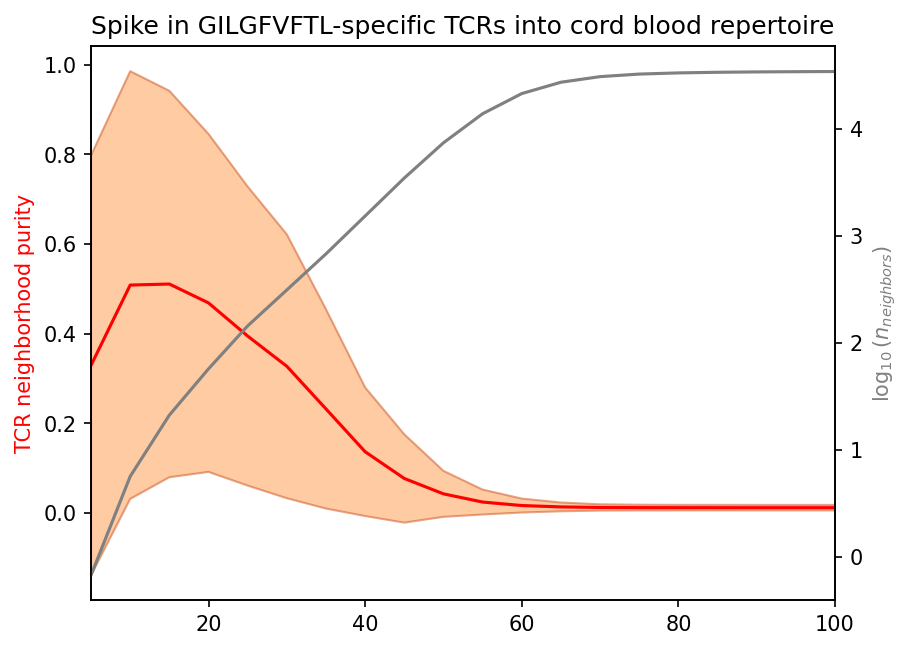

In [56]:
fig, ax = plt.subplots(dpi=150)

final_avg = final.groupby('radius').mean()
final_std = final.groupby('radius').std()
ntcr = len(final.tcr.unique())

pmax = np.round(final_avg.purity.max(), 2)
maxid = final_avg.purity.idxmax()
stdmax = np.round(final_std.purity[maxid], 2)

x = final_avg.index
y1 = final_avg.purity
y2 = final_avg.ncluster
error1 = final_std.purity
error2 = final_std.ncluster

cdr3str = 'CDR3'
ax.fill_between(x, y1-error1, y1+error1, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848', zorder=1)
ax.plot(x, y1, color='red', zorder=1)
ax.set_xlim(5,100)
# ax.set_title(f'Length {l} (n = {ntcr})\nmax(r) = {maxid}', fontsize=8)
# ax.set_xticklabels([0,50,100,150], fontsize=6)
ax.set_ylabel('TCR neighborhood purity', color='red')

ax2 = ax.twinx()
# ax2.fill_between(x, np.log10(y2-error2), np.log10(y2+error2), alpha=0.5, edgecolor='grey', facecolor='lightgray')
ax2.plot(x, np.log10(y2), color='grey', zorder=0)
ax2.set_ylabel(r'$\log_{10}(n_{neighbors})$', color='grey')

ax.set_title('Spike in GILGFVFTL-specific TCRs into cord blood repertoire')

In [55]:
final.sort_values(by='purity', ascending=False).iloc[1000]

radius       10.000000
purity        0.944444
ncluster     18.000000
tcr         928.000000
Name: 1, dtype: float64

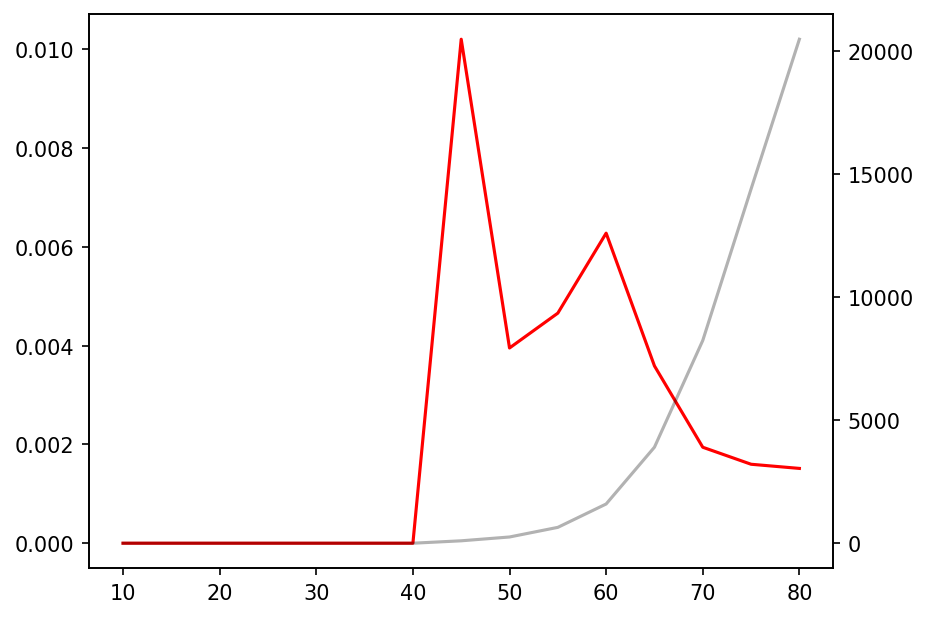

In [43]:
pspike = radius_range(ovl, mindist=10, maxdist=80, stepsize=5)

fig, ax = plt.subplots(dpi=150)

x = pspike.radius
y1 = pspike.purity
y2 = pspike.ncluster

ax.plot(x,y1,c='red')

ax2 = ax.twinx()
ax2.plot(x,y2,c='black',alpha=.3)